# Task 2 - The Modern Hybrid Baseline

We will load a pretrained CNN (resnet18) and remove the final classification layer. This allows us to extract a feature map consisting of 512 nodes. 

## Load data and model

First, we load the training and validation dataframes as constructed in task 1:

In [55]:
import pandas as pd
import numpy as np

# load df from my_dataframe.csv
train_df = pd.read_csv('train_dataframe.csv', index_col=0)
val_df = pd.read_csv('val_dataframe.csv', index_col=0)

print("Head of training data loaded from file: \n",train_df.head())

Head of training data loaded from file: 
                                                filepath       type   id  \
419   ../NEU-DET/train/images\inclusion\inclusion_44...  inclusion   44   
675      ../NEU-DET/train/images\patches\patches_59.jpg    patches   59   
748   ../NEU-DET/train/images\pitted_surface\pitted_...     pitted  124   
226      ../NEU-DET/train/images\crazing\crazing_87.jpg    crazing   87   
1163  ../NEU-DET/train/images\rolled-in_scale\rolled...  rolled-in   66   

                                           hog_features  \
419   [0.2369237  0.15415997 0.21013955 ... 0.213794...   
675   [0.29324098 0.03451908 0.13982935 ... 0.068845...   
748   [0.25374744 0.25374744 0.25374744 ... 0.115656...   
226   [0.22393232 0.08401035 0.22393232 ... 0.095062...   
1163  [0.19847726 0.07978102 0.13506998 ... 0.099056...   

                                          glcm_features  
419   [1.27806533e+01 1.72544128e+01 8.23502513e+00 ...  
675   [3.07574196e+02 4.26079543e+02

Next, we import the ResNet18 model: 

In [56]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights

# Load a pre-trained ResNet18 model
model = models.resnet18(weights=ResNet18_Weights.DEFAULT) # parameter 'pretrained' is deprecated
print("model loaded correctly: \n", model)

model loaded correctly: 
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (re


The pytorch [website](https://docs.pytorch.org/vision/0.8/models.html) states 

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:

which has been implemented in the following way, while we also remove the final classification layer 

In [57]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),   # ResNet expects at least 224x224
    transforms.ToTensor(),           # convert to tensor [0,1]
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])

# Remove the final classification layer, keep everything up to the penultimate
model = nn.Sequential(*list(model.children())[:-1])  # outputs [batch, 512, 1, 1]
model.eval()

print("The model used to extract features from the input images is: \n", model)



The model used to extract features from the input images is: 
 Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

## Run model

We can run the model by applying a 'extract_resnet_features' function to each path in the df:

In [58]:
from PIL import Image

# helper function to extract features from a single image
def extract_resnet_features(filepath, model, transform, device="cpu"):
    img = Image.open(filepath).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)  # add batch dim
    with torch.no_grad():
        features = model(img_t)  # shape [1, 512, 1, 1]
    return features.squeeze().cpu().numpy()  # -> (512,)

# Only CPU available on my machine :(
device = "cpu"
model.to(device)

# Extract features using helper function and add to dataframe
train_df["resnet_features"] = train_df["filepath"].apply(
    lambda fp: extract_resnet_features(fp, model, transform, device)
)
val_df["resnet_features"] = val_df["filepath"].apply(
    lambda fp: extract_resnet_features(fp, model, transform, device)
)

## Classification - Random Forest

Just like in task 1, we can use these features to train a RF classifier. using 100 estimators and a random state equal to 1 for reproducibility gives the following results for the validation set:

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train = np.vstack(train_df["resnet_features"])
y_train = train_df["type"].values

X_val = np.vstack(val_df["resnet_features"])
y_val = val_df["type"].values

clf = RandomForestClassifier(n_estimators=100, random_state=1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

     crazing       1.00      0.98      0.99        60
   inclusion       0.95      1.00      0.98        60
     patches       0.98      0.98      0.98        60
      pitted       0.98      0.98      0.98        60
   rolled-in       1.00      1.00      1.00        60
   scratches       1.00      0.97      0.98        60

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



With the following confusion matrix

In [60]:
# get confusion matrix
from sklearn.metrics import confusion_matrix

types = np.unique(y_train)

cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm, index=types, columns=types)
print("Confusion Matrix:\n", cm_df)

Confusion Matrix:
            crazing  inclusion  patches  pitted  rolled-in  scratches
crazing         59          0        1       0          0          0
inclusion        0         60        0       0          0          0
patches          0          0       59       1          0          0
pitted           0          1        0      59          0          0
rolled-in        0          0        0       0         60          0
scratches        0          2        0       0          0         58


In [61]:
classification_report_df = pd.DataFrame(classification_report(y_val, y_pred, output_dict=True)).transpose()
classification_report_df.to_csv('task2_classification_report.csv', index=True)

## Conclusion 

The score has significantly improved for all defects compared to the model from task 1. In the validation set, 5% of scratches have been labeled as inclusions (3 images) which are the only mistakes made by the model.

Number of misclassified images: 5 out of 60


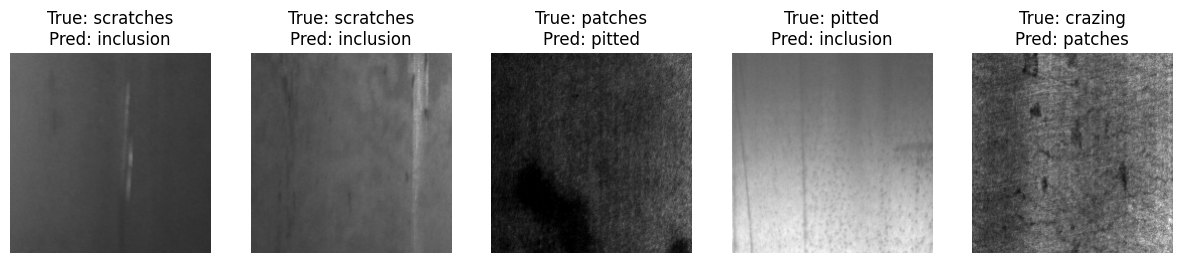

In [62]:
# find example of misclassified images
import matplotlib.pyplot as plt
misclassified_indices = np.where(y_val != y_pred)[0]

# get number of misclassified images
num_misclassified = len(misclassified_indices)
print(f"Number of misclassified images: {num_misclassified} out of {len(y_val)//6}")

# plot all misclassified images in a row
plt.figure(figsize=(15, 5))
for i, idx in enumerate(misclassified_indices):
    img = Image.open(val_df.iloc[idx]["filepath"]).convert("RGB")
    plt.subplot(1, num_misclassified, i + 1)
    plt.imshow(img)
    plt.title(f"True: {y_val[idx]}\nPred: {y_pred[idx]}")
    plt.axis('off')
plt.show()



The image above shows the 3 mislabel images. Upon visual inspection, there are other factors which might confuse the model, like darker straks trhough the image or a curved lighter area. 

The code below saves any relevant information to be used in task 3.

In [63]:
# generate df with misclassified images
misclassified_df = val_df.iloc[misclassified_indices].copy()
# add what it was misclassified as
misclassified_df['predicted_type'] = y_pred[misclassified_indices]
misclassified_df.to_csv('misclassified_images_2.csv', index=False)